# Classification. Thyroid Disease Data Set

# Loading the needed libraries

In [15]:
from pandas_profiling import ProfileReport

import pandas as pd
import numpy as np
from scipy import sparse
import scipy.stats as stats

import seaborn as sns

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import os
import itertools

import warnings
warnings.filterwarnings('ignore')

import math

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, make_scorer, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

from sklearn.decomposition import PCA, TruncatedSVD

import category_encoders

from imblearn.over_sampling import RandomOverSampler

# Loading the data

In [9]:
all_data = pd.read_csv('Thyroid_Disease_dataset.csv')
display(all_data.shape)

(3772, 30)

# EDA

In [10]:
all_data.head().T

,0,1,2,3,4
age,41,23,46,70,70
sex,F,F,M,F,F
on_thyroxine,f,f,f,t,f
query_on_thyroxine,f,f,f,f,f
on_antithyroid_medication,f,f,f,f,f
sick,f,f,f,f,f
pregnant,f,f,f,f,f
thyroid_surgery,f,f,f,f,f
I131_treatment,f,f,f,f,f
query_hypothyroid,f,f,f,f,f


Предпологаем, что все знаки ? в данных соответствуют отсутствию показаний. Поэтому заменим их на NaN для удобства обработки

In [11]:
all_data = all_data.replace('?', np.nan)

Посмотрим, есть ли пропуски в целевой переменной

In [12]:
all_data['Class'].isnull().sum()

0

Данные с пропусками в целевой переменной точно были бы удалены. Но в нашем примере этого делать не придётся

Проверим сбалансированность классов

In [13]:
all_data['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

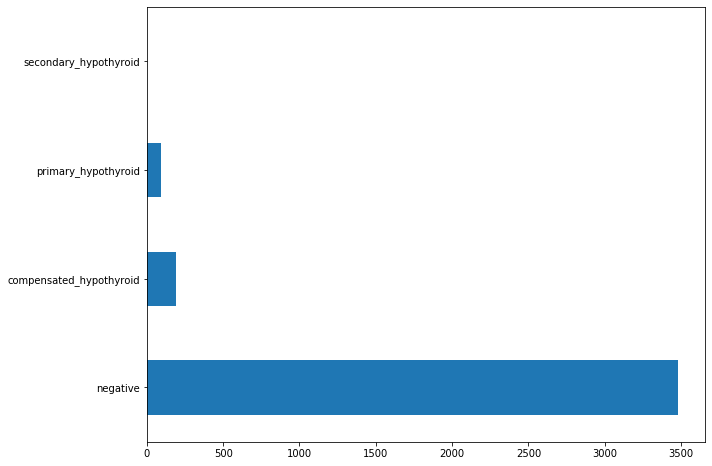

In [17]:
all_data['Class'].value_counts().plot.barh(figsize=(10, 8));

Классы сильно дисбалансированы: здоровых пациентов значительно больше, чем больных

С целью хоть немного сбалансировать данные, объединим всех людей с заболеваниями в один класс и ещё раз посмотрим на график. Такое преобразование обязывает нас применять ещё один классиффикатор для определения конкретного заболевания у человека, которого первый классификатор посчитал больным.

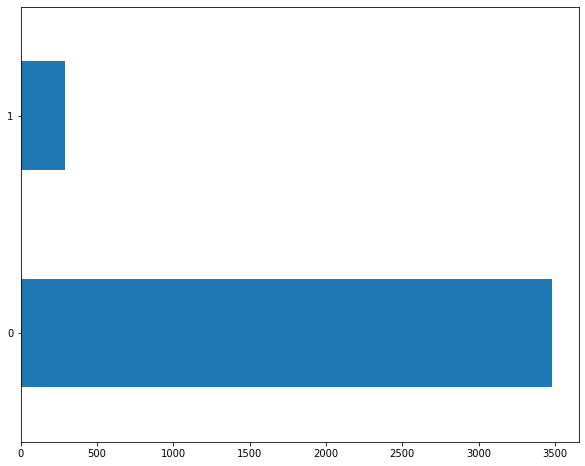

In [20]:
all_data['Class'] = all_data['Class'].replace([
    'secondary_hypothyroid', 'primary_hypothyroid', 'compensated_hypothyroid'
], 1)
all_data['Class'] = all_data['Class'].replace('negative', 0)

all_data['Class'].value_counts().plot.barh(figsize=(10, 8));

# Data preparation

Изучим отчёт о тренировочном датасете

In [21]:
ProfileReport(all_data)

Number of variables,30
Number of observations,3772
Total Missing (%),5.4%
Total size in memory,884.2 KiB
Average record size in memory,240.0 B
Numeric,0
Categorical,27
Boolean,1
Date,0
Text (Unique),0
Rejected,2


1. Большое количество категориальных переменных на самом деле являются численными
2. 3 переменных имеют постоянное значение. Эти переменные будут удалены во всём датасете (не только тренировочном)

Удалим переменные с константными значениями

In [22]:
all_data = all_data.drop(['TBG', 'TBG_measured', 'hypopituitary'], 1)

Переведём категориальные (которые на самом деле являются численными) переменные в численные

In [23]:
to_numeric = ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']
for cat in to_numeric:
    all_data[cat] = pd.to_numeric(all_data[cat])

Перевод категориальных переменных в бинарные

In [24]:
all_data = all_data.replace('t', 1)
all_data = all_data.replace('f', 0)

all_data['sex'] = all_data['sex'].replace('M', 1)
all_data['sex'] = all_data['sex'].replace('F', 0)

all_data = all_data.rename(index=str, columns={"sex": "Male"})

Закодируем категориальный признак и сравним размерности до и после преобразования

In [25]:
display(all_data.shape)

pipeline = make_pipeline(
    category_encoders.OneHotEncoder(handle_unknown="ignore",
                                    use_cat_names=True))
all_data = pipeline.fit_transform(all_data)

display(all_data.shape)

(3772, 27)

(3772, 31)

In [26]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3772 entries, 0 to 3771
Data columns (total 31 columns):
referral_source_SVHC         3772 non-null int32
referral_source_other        3772 non-null int32
referral_source_SVI          3772 non-null int32
referral_source_STMW         3772 non-null int32
referral_source_SVHD         3772 non-null int32
age                          3771 non-null float64
Male                         3622 non-null float64
on_thyroxine                 3772 non-null int64
query_on_thyroxine           3772 non-null int64
on_antithyroid_medication    3772 non-null int64
sick                         3772 non-null int64
pregnant                     3772 non-null int64
thyroid_surgery              3772 non-null int64
I131_treatment               3772 non-null int64
query_hypothyroid            3772 non-null int64
query_hyperthyroid           3772 non-null int64
lithium                      3772 non-null int64
goitre                       3772 non-null int64
tumor       

Также замечаем, что переменные, содержащие "measured", смысла в себе не несут. У пациентов, у которых в графе "measured" стоит "false", в соответствующем показании стоял "?", то есть графы "measured" являются избыточными. Удалим их

In [27]:
all_data = all_data[all_data.columns.drop(
    list(all_data.filter(regex='measured')))]

In [28]:
ProfileReport(all_data)

Number of variables,27
Number of observations,3772
Total Missing (%),2.3%
Total size in memory,722.1 KiB
Average record size in memory,196.0 B
Numeric,7
Categorical,0
Boolean,19
Date,0
Text (Unique),1
Rejected,0


Данных с пропусками в целом не так много, но у признака "T3" пропущено 20% значений. Без веского повода удалять пятую часть данных не хотелось бы. Попробуем пропущенные значения этого признака восстановить. Можно заметить некоторую корреляцию признака "T3" с признаком "TT4". Построим диаграмму рассеяния и выведем коэффициент корреляции Пирсона

(0.5735724915254349, 4.282085281337242e-231)

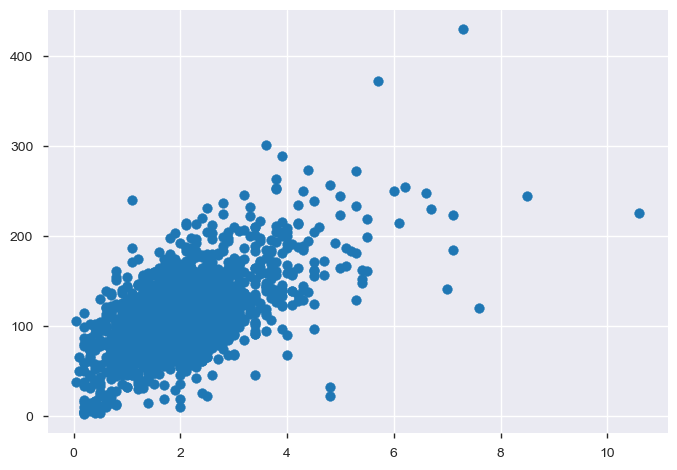

In [29]:
plt.scatter(all_data['T3'], all_data['TT4'])
stats.pearsonr(all_data.dropna()['T3'], all_data.dropna()['TT4'])

Корреляция заметная. Возможно, её достаточно для восстановления значений. Найдём строки, в которых оба признака известны. Эти строки будут использованы для обучения модели линейной регрессии

In [30]:
usable_for_train = all_data[(all_data['T3'] == all_data['T3'])
                            & (all_data['TT4'] == all_data['TT4'])]

Выделим целевую переменную, в тренировочном сете оставим только интересующий нас признак. Пришлось добавить ещё один признак и сделать его значение постоянным, так как модели регрессии не работают с одним признаком

In [31]:
target = usable_for_train['T3']

usable_for_train = usable_for_train[['TT4', 'Male']]
usable_for_train['Male'] = 1

Были испробованы следующие модели регрессии: SVR, DecisionTreeRegressor, KNeighborsRegressor. Но лучшие результаты дала обычная линейная регрессия

In [34]:
train_feats, test_feats, train_target, test_target = train_test_split(
    usable_for_train, target, test_size=0.3)

linreg = LinearRegression()
linreg.fit(train_feats, train_target)
linreg.score(test_feats, test_target)

0.31611656083657624

Такая модель может только ухудшить результаты классификации. Посмотрим, связан ли признак с целевой переменной. Возможно, этот признак можно просто удалить

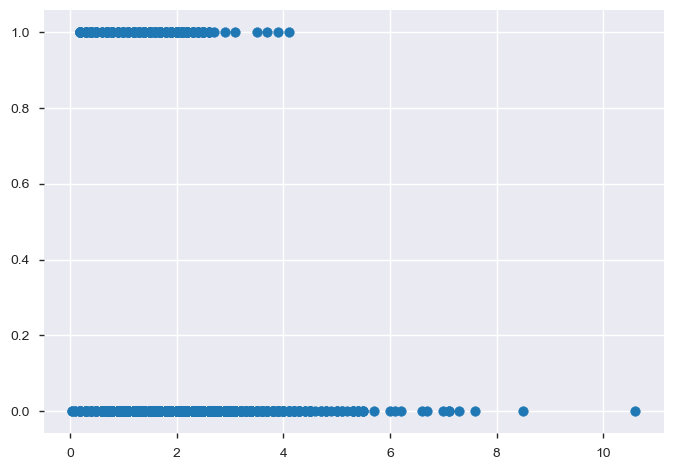

In [35]:
plt.scatter(all_data['T3'], all_data['Class']);

Некоторая зависимость прослеживается: нет больных с показанием T3 > 4. Получается, удалить признак тоже нельзя. Придётся удалять все данные, содержащие пропуски

In [36]:
all_data = all_data.dropna()

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2643 entries, 0 to 3771
Data columns (total 26 columns):
referral_source_SVHC         2643 non-null int32
referral_source_other        2643 non-null int32
referral_source_SVI          2643 non-null int32
referral_source_STMW         2643 non-null int32
referral_source_SVHD         2643 non-null int32
age                          2643 non-null float64
Male                         2643 non-null float64
on_thyroxine                 2643 non-null int64
query_on_thyroxine           2643 non-null int64
on_antithyroid_medication    2643 non-null int64
sick                         2643 non-null int64
pregnant                     2643 non-null int64
thyroid_surgery              2643 non-null int64
I131_treatment               2643 non-null int64
query_hypothyroid            2643 non-null int64
query_hyperthyroid           2643 non-null int64
lithium                      2643 non-null int64
goitre                       2643 non-null int64
tumor       

Было замечено, что переменная Male получает вещественный тип, хотя имеет всего два значения: 0 и 1. Приведём её к целочисленному типу

In [37]:
all_data['Male'] = all_data['Male'].astype(np.int64)

# Outlier analysis for numerical features
Попробуем найти выбросы. Для этого построим графики boxplot

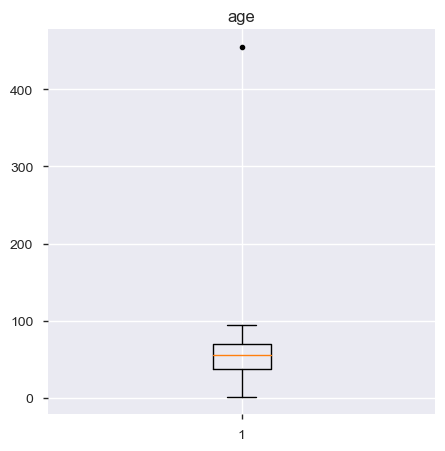

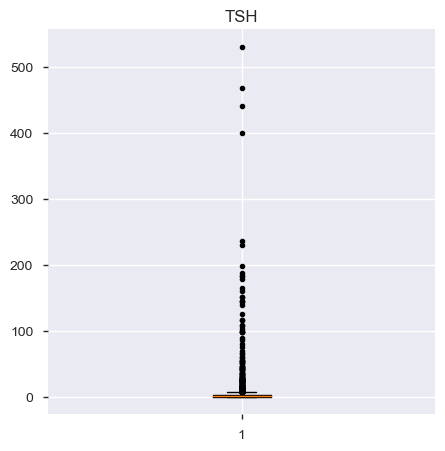

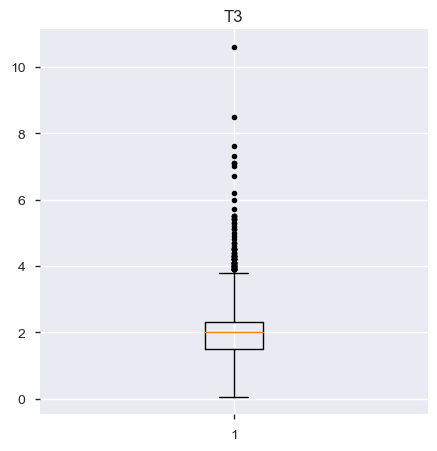

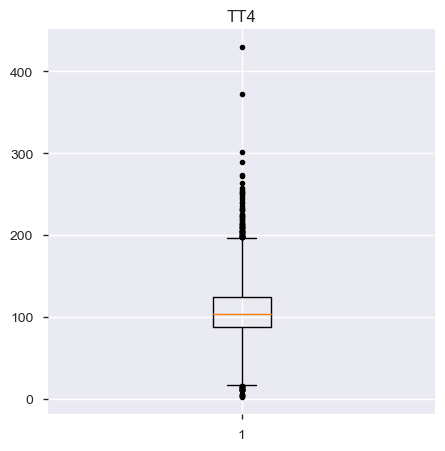

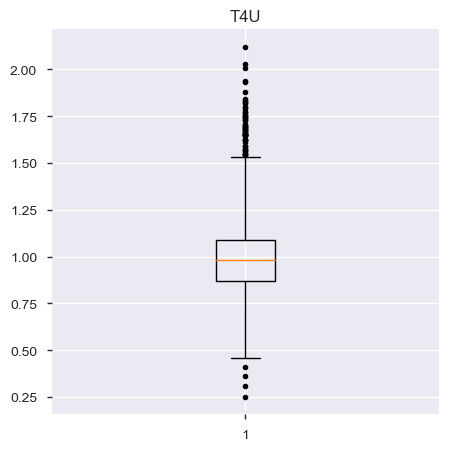

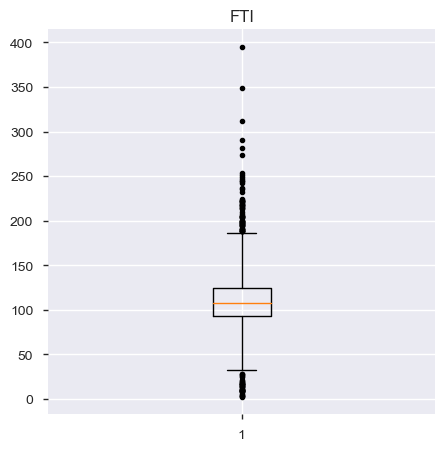

In [38]:
numeric_feats = all_data.dtypes[all_data.dtypes == "float64"].index

for i in numeric_feats:
    plt.figure(figsize=(5, 5))
    plt.title(i)
    plt.boxplot(all_data[i], sym='k.', whis=2)
    plt.show()

Долгожителя с возрастом >400 лет сразу отклоняем. Это очевидный выброс

In [39]:
all_data = all_data[all_data['age'] < 400]

Распределение переменной TSH очень напоминает распределение целевой переменной-большая доля показаний сосредоточена у нуля, однако присутствует явно неслучайно большое количество больших значений. Выведем пациентов, с показателем TSH выше 100

In [40]:
all_data[all_data['TSH'] > 100]

,referral_source_SVHC,referral_source_other,referral_source_SVI,referral_source_STMW,referral_source_SVHD,age,Male,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,...,lithium,goitre,tumor,psych,TSH,T3,TT4,T4U,FTI,Class
88,0,1,0,0,0,39.0,0,0,0,0,...,0,0,0,0,160.0,0.4,11.0,1.24,8.9,1
116,0,1,0,0,0,50.0,1,0,0,0,...,0,0,0,0,151.0,1.0,32.0,1.16,28.0,1
224,0,1,0,0,0,79.0,0,0,0,0,...,0,0,0,0,143.0,0.7,73.0,1.01,72.0,1
259,0,0,1,0,0,63.0,1,0,0,0,...,0,0,0,0,108.0,0.4,14.0,0.98,14.0,1
639,0,0,1,0,0,44.0,1,0,0,0,...,0,0,0,0,199.0,0.6,10.0,1.03,10.0,1
659,0,1,0,0,0,31.0,0,0,0,0,...,0,0,0,0,188.0,1.3,63.0,1.19,53.0,1
944,0,0,1,0,0,28.0,0,0,0,0,...,0,0,0,0,103.0,2.1,65.0,1.16,56.0,1
1375,0,1,0,0,0,53.0,0,0,0,0,...,0,0,0,0,183.0,1.4,14.0,1.31,11.0,1
1618,0,1,0,0,0,60.0,0,0,0,0,...,0,0,0,0,151.0,1.4,42.0,1.06,39.0,1
2057,0,1,0,0,0,63.0,0,0,0,0,...,0,0,0,0,126.0,1.3,39.0,1.08,37.0,1


Почти все из них больны. Делаем выводы:
1. Признак TSH заметно связан с целевой переменной
2. Значения признака не являются выбросами

Про связь признака T3 с целевой переменной было сказано выше

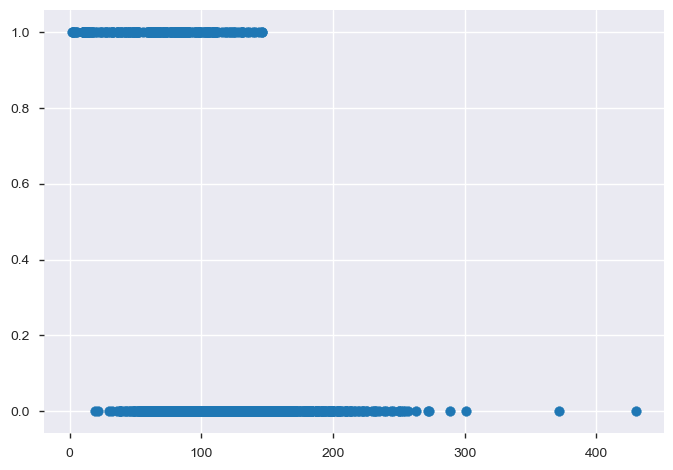

In [41]:
plt.scatter(all_data['TT4'], all_data['Class']);

Видим ситуацию, аналогичную у переменной T3: нет больных со показанием TT4 > 150. То, что кажется выбросом, может быть фактором, определяющим класс. Поэтому выбросы также не удаляются

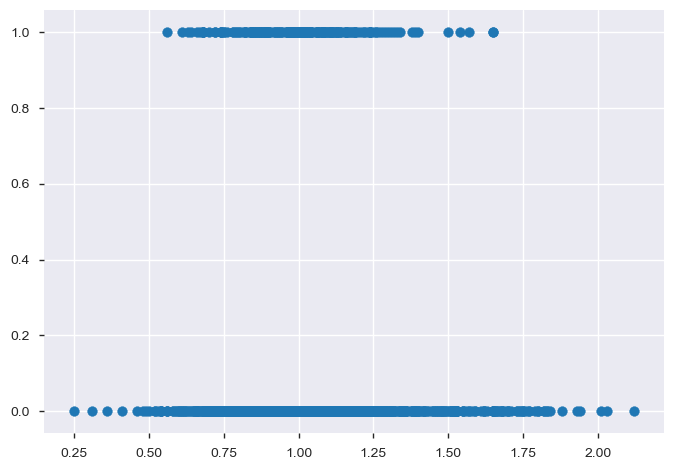

In [42]:
plt.scatter(all_data['T4U'], all_data['Class']);

И у больных, и у здоровых данный показатель выглядит очень похожим. У здоровых разброс больше ввиду их большего количества. Переменную можно удалить

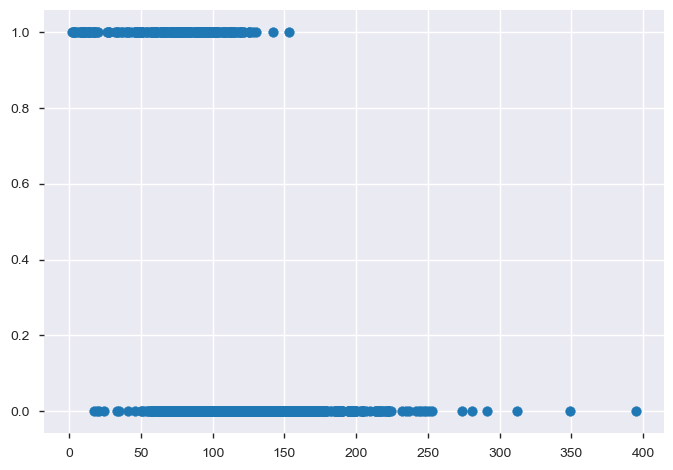

In [44]:
all_data = all_data.drop('T4U', 1)

numeric_feats = numeric_feats.drop('T4U', 1)

plt.scatter(all_data['FTI'], all_data['Class']);

Заключаем, что у больных данный признак имеет заметно более низкие показатели, чем у здоровых. Выбросы также оставляем

# Handling binary features
Попробуем взглянуть на бинарные признаки поближе. Возможно, среди них найдём те, которые можно выбросить без ущерба для модели.

Выделим бинарные признаки

In [45]:
binary_feats = all_data.columns

for feat in numeric_feats:
    binary_feats = binary_feats.drop(feat, 1)

binary_feats.shape

(20,)

Для поиска напишем функцию. Функция показывает количество случаев, когда присутствует или отсутствует признак для каждого из возможных состояний пациента (болен или здоров).  
**Предполагается, что для признака, который никак не коррелирован с целевой переменной, доли пациентов с наличием и отсутствием признака у обоих классов будут одинаковыми.**

In [46]:
def show_cases(feat):
    feat0_tar0 = all_data.loc[(all_data[feat] == 0)
                              & (all_data['Class'] == 0)].count()[0]
    feat0_tar1 = all_data.loc[(all_data[feat] == 0)
                              & (all_data['Class'] == 1)].count()[0]
    feat1_tar0 = all_data.loc[(all_data[feat] == 1)
                              & (all_data['Class'] == 0)].count()[0]
    feat1_tar1 = all_data.loc[(all_data[feat] == 1)
                              & (all_data['Class'] == 1)].count()[0]

    df = pd.DataFrame(data={
        'Class == 0':
        [feat0_tar0, feat1_tar0, feat1_tar0 / (feat0_tar0 + feat1_tar0)],
        'Class == 1':
        [feat0_tar1, feat1_tar1, feat1_tar1 / (feat0_tar1 + feat1_tar1)]
    },
                      index=[feat + ' == 0', feat + ' == 1', 'ratio'])

    return df

In [47]:
binary_feats = all_data.dtypes[all_data.dtypes != "float64"].index
binary_feats = binary_feats.drop('Class', 1)

for feat in binary_feats:
    display(show_cases(feat))

,Class == 0,Class == 1
referral_source_SVHC == 0,2078.000000,205.000000
referral_source_SVHC == 1,348.000000,11.000000
ratio,0.143446,0.050926


,Class == 0,Class == 1
referral_source_other == 0,1305.000000,100.000000
referral_source_other == 1,1121.000000,116.000000
ratio,0.462077,0.537037


,Class == 0,Class == 1
referral_source_SVI == 0,1582.000000,132.000000
referral_source_SVI == 1,844.000000,84.000000
ratio,0.347898,0.388889


,Class == 0,Class == 1
referral_source_STMW == 0,2344.0000,214.000000
referral_source_STMW == 1,82.0000,2.000000
ratio,0.0338,0.009259


,Class == 0,Class == 1
referral_source_SVHD == 0,2395.000000,213.000000
referral_source_SVHD == 1,31.000000,3.000000
ratio,0.012778,0.013889


,Class == 0,Class == 1
Male == 0,1596.000000,167.000000
Male == 1,830.000000,49.000000
ratio,0.342127,0.226852


,Class == 0,Class == 1
on_thyroxine == 0,2167.00000,209.000000
on_thyroxine == 1,259.00000,7.000000
ratio,0.10676,0.032407


,Class == 0,Class == 1
query_on_thyroxine == 0,2404.000000,214.000000
query_on_thyroxine == 1,22.000000,2.000000
ratio,0.009068,0.009259


,Class == 0,Class == 1
on_antithyroid_medication == 0,2394.00000,215.00000
on_antithyroid_medication == 1,32.00000,1.00000
ratio,0.01319,0.00463


,Class == 0,Class == 1
sick == 0,2322.000000,207.000000
sick == 1,104.000000,9.000000
ratio,0.042869,0.041667


,Class == 0,Class == 1
pregnant == 0,2385.0000,216.0
pregnant == 1,41.0000,0.0
ratio,0.0169,0.0


,Class == 0,Class == 1
thyroid_surgery == 0,2394.00000,215.00000
thyroid_surgery == 1,32.00000,1.00000
ratio,0.01319,0.00463


,Class == 0,Class == 1
I131_treatment == 0,2387.000000,215.00000
I131_treatment == 1,39.000000,1.00000
ratio,0.016076,0.00463


,Class == 0,Class == 1
query_hypothyroid == 0,2305.000000,191.000000
query_hypothyroid == 1,121.000000,25.000000
ratio,0.049876,0.115741


,Class == 0,Class == 1
query_hyperthyroid == 0,2277.000000,202.000000
query_hyperthyroid == 1,149.000000,14.000000
ratio,0.061418,0.064815


,Class == 0,Class == 1
lithium == 0,2413.000000,215.00000
lithium == 1,13.000000,1.00000
ratio,0.005359,0.00463


,Class == 0,Class == 1
goitre == 0,2406.000000,216.0
goitre == 1,20.000000,0.0
ratio,0.008244,0.0


,Class == 0,Class == 1
tumor == 0,2373.000000,211.000000
tumor == 1,53.000000,5.000000
ratio,0.021847,0.023148


,Class == 0,Class == 1
psych == 0,2263.000000,209.000000
psych == 1,163.000000,7.000000
ratio,0.067189,0.032407


Удалим переменные, у которых ratio для больных и здоровых почти одинаковый. 

In [48]:
all_data = all_data.drop([
    'referral_source_other',
    'referral_source_SVI',
    'referral_source_SVHD',
    'query_on_thyroxine',
    'sick',
    'query_hyperthyroid',
    'lithium',
    'tumor',
], 1)

binary_feats = binary_feats.drop([
    'referral_source_other',
    'referral_source_SVI',
    'referral_source_SVHD',
    'query_on_thyroxine',
    'sick',
    'query_hyperthyroid',
    'lithium',
    'tumor',
], 1)

In [49]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2642 entries, 0 to 3771
Data columns (total 17 columns):
referral_source_SVHC         2642 non-null int32
referral_source_STMW         2642 non-null int32
age                          2642 non-null float64
Male                         2642 non-null int64
on_thyroxine                 2642 non-null int64
on_antithyroid_medication    2642 non-null int64
pregnant                     2642 non-null int64
thyroid_surgery              2642 non-null int64
I131_treatment               2642 non-null int64
query_hypothyroid            2642 non-null int64
goitre                       2642 non-null int64
psych                        2642 non-null int64
TSH                          2642 non-null float64
T3                           2642 non-null float64
TT4                          2642 non-null float64
FTI                          2642 non-null float64
Class                        2642 non-null int64
dtypes: float64(5), int32(2), int64(10)
memory usage: 4

Таким образом получилось удалить почти половину переменных

Отделим целевую переменную

In [50]:
target = all_data.pop('Class')
display(all_data.shape, target.shape)

(2642, 16)

(2642,)

# Creating a pipeline

Попробуем сделать простой pipeline. Численные данные будут стандартизованы, бинарные останутся прежними. В качестве модели будем использовать логистическую регрессию

**Веса классов в логистической регрессии выбираем balanced, чтобы учесть несбалансированность**

In [51]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]


LR_pipe = Pipeline([
    ("transformer",
     FeatureUnion([('numeric',
                    make_pipeline(Columns(names=numeric_feats),
                                  StandardScaler())),
                   ('other', make_pipeline(Columns(names=binary_feats), ))])),
    ('clf', LogisticRegression(class_weight='balanced'))
])

Разобьём данные на тренировочные и тестовые выборки.  
**Стратификация производится пропорционально значениям в целевой переменной**

In [52]:
train_data, test_data, train_target, test_target = train_test_split(
    all_data, target, test_size=0.3, random_state=17, stratify=target)

Обучим модель на тренировочных данных

In [53]:
LR_pipeline_model = LR_pipe.fit(train_data, train_target)

Выборка сильно несбалансирована и поэтому верить метрике "доля правильных ответов" нельзя. Но всё равно выведем её)

In [54]:
LR_pipeline_model.score(test_data, test_target)

0.9848675914249685

## Теперь попробуем проделать те же операции, но без использования pipeline

### Стандартизация

In [55]:
scaler = StandardScaler()

Так как некоторые признаки имеют различие примерно в два порядка, имеет смысл их стандартизовать

In [56]:
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

train_data_scaled[numeric_feats] = scaler.fit_transform(
    train_data_scaled[numeric_feats])

test_data_scaled[numeric_feats] = scaler.transform(
    test_data_scaled[numeric_feats])

### Логистическая регрессия

Создадим модель логистической регрессии и обучим её на тренировочных данных

In [57]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(train_data_scaled, train_target)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Выведем метрику

In [58]:
print(logreg.score(test_data_scaled, test_target))

0.9848675914249685


Метрики совпали. Использование pipeline сделало код более компактным и удобным в использовании

## Cross-validation

На всякий случай проведём кросс-валидацию с целью предупредить переобучение

In [59]:
scoring = 'accuracy'
modelCV = LR_pipeline_model
splits = [2, 3, 5, 10, 15, 30, 50]
for i in splits:
    kfold = KFold(n_splits=i, random_state=7)
    results = cross_val_score(modelCV,
                              train_data,
                              train_target,
                              cv=kfold,
                              scoring=scoring)
    print(i,
          "- fold cross-validation average accuracy: %.3f" % (results.mean()))

2 - fold cross-validation average accuracy: 0.962
3 - fold cross-validation average accuracy: 0.969
5 - fold cross-validation average accuracy: 0.967
10 - fold cross-validation average accuracy: 0.968
15 - fold cross-validation average accuracy: 0.970
30 - fold cross-validation average accuracy: 0.972
50 - fold cross-validation average accuracy: 0.971


Средние доли правильных ответов очень близки к доле первоначальной модели, следовательно, можем заключить, что наша модель не переобучается

# Metrics

Вычислим матрицу ошибок.

In [60]:
pred_target = LR_pipeline_model.predict(test_data)

confus_matrix = confusion_matrix(test_target, pred_target)

Выведем матрицу ошибок. При этом приведём заметку из спецификации
![alt text](matrix_index.png "Title")

In [61]:
print(confus_matrix)

[[717  11]
 [  1  64]]


В первой строке располагаются здоровые пациенты, во второй - пациенты с одной из трёх разновидностей исследуемого заболевания.

В левом столбце находятся пациенты, которых алгоритм классифицировал как здоровых, а в правом-как больных

Получается, данная модель случайно отнесла к больным 11 здоровых людей ( что не страшно: можно ещё раз провести диагностику), но "не заметила" одного действительно больного пациента!

Ошибки в данной задаче имеют разную цену, поэтому лучше использовать такие метрики качества как точность (precision) и полнота (recall)

**В нашей задаче главной ценностью является нахождение всех действительно больных людей, то есть мы хотим максимально повысить recall для объектов класса 1. При этом точность (precision) играет второстепенную роль, точность будем повышать по возможности (не хотелось бы каждого пациента обследовать по несколько раз).**

Посмотрим на эти характеристики

In [62]:
clf_report = classification_report(test_target, pred_target)

In [63]:
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       728
           1       0.85      0.98      0.91        65

    accuracy                           0.98       793
   macro avg       0.93      0.98      0.95       793
weighted avg       0.99      0.98      0.99       793



Наш алгоритм распознал 98% больных, это очень хороший показатель, но хотелось бы довести его до 100%

Создадим две функции для вывода графиков ROC и PR кривых и площадей под ними. Так как наша выборка сильно дисбалансирована, пользоваться будем PR метрикой

In [64]:
def show_auc_roc(test_target, pred_target):
    logit_roc_auc = roc_auc_score(test_target, pred_target)
    fpr, tpr, thresholds = roc_curve(test_target, pred_target)
    plt.figure()
    plt.plot(fpr,
             tpr,
             label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.savefig('Log_ROC')
    plt.show()


def show_auc_prc(test_target, pred_target):
    precision, recall, _ = precision_recall_curve(test_target, pred_target)
    plt.figure(figsize=(5, 3))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    auc = average_precision_score(test_target, pred_target)
    plt.title(''.join(['2-class Precision-Recall curve: ', str(auc)]))

    return auc

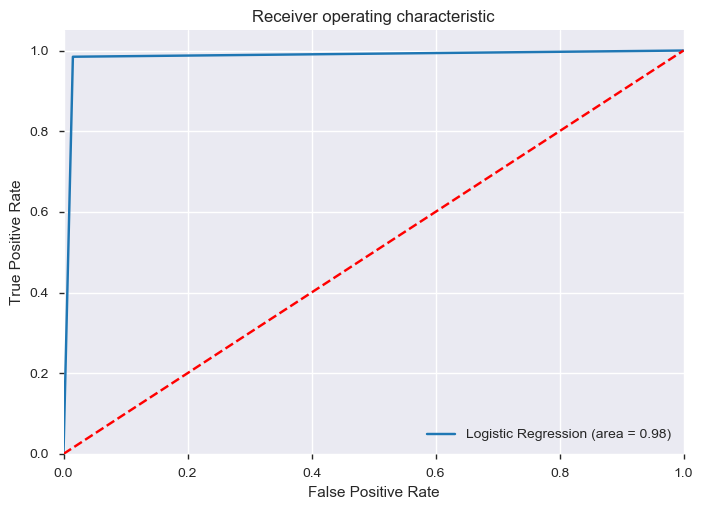

In [65]:
show_auc_roc(test_target, pred_target)

0.8414661622530476

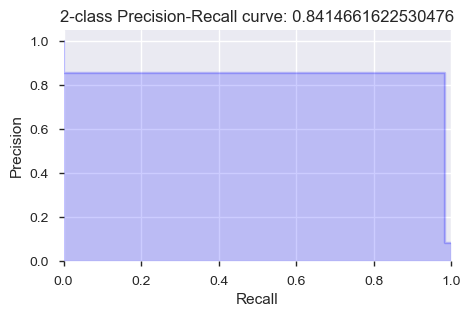

In [66]:
show_auc_prc(test_target, pred_target)

# Feature generation

В данной ситуации сложно придумать какие-либо признаки со стороны. Поэтому просто добавим степени и логарифм для численных переменных

In [67]:
all_data_pow = all_data.copy()

for feat in numeric_feats:
    square_name = feat + '_square'
    all_data_pow[square_name] = all_data_pow[feat]**2

    cube_name = feat + '_cube'
    all_data_pow[cube_name] = all_data_pow[feat]**3

    exp_name = feat + '_exp'
    all_data_pow[exp_name] = np.exp(all_data_pow[feat])

    log1p_name = feat + '_log1p'
    all_data_pow[log1p_name] = np.log1p(all_data_pow[feat])

    sqrt_name = feat + '_sqrt'
    all_data_pow[sqrt_name] = np.sqrt(all_data_pow[feat])

In [68]:
all_data_pow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2642 entries, 0 to 3771
Data columns (total 41 columns):
referral_source_SVHC         2642 non-null int32
referral_source_STMW         2642 non-null int32
age                          2642 non-null float64
Male                         2642 non-null int64
on_thyroxine                 2642 non-null int64
on_antithyroid_medication    2642 non-null int64
pregnant                     2642 non-null int64
thyroid_surgery              2642 non-null int64
I131_treatment               2642 non-null int64
query_hypothyroid            2642 non-null int64
goitre                       2642 non-null int64
psych                        2642 non-null int64
TSH                          2642 non-null float64
T3                           2642 non-null float64
TT4                          2642 non-null float64
FTI                          2642 non-null float64
age_square                   2642 non-null float64
age_cube                     2642 non-null float64
ag

Для удобства сравнения моделей напишем функцию

In [69]:
def fit_model_show_metrics(model, data, target, auc_prc=True):
    train_data, test_data, train_target, test_target = train_test_split(
        data, target, test_size=0.3, random_state=17, stratify=target)
    print('train data size : ', train_data.shape, '\ntrain target size: ',
          train_target.shape[0], '\n')

    model.fit(train_data, train_target)
    pred_target = model.predict(test_data)

    confus_matrix = confusion_matrix(test_target, pred_target)
    print(confus_matrix, '\n')

    clf_report = classification_report(test_target, pred_target)
    print(clf_report)

    if auc_prc:
        show_auc_prc(test_target, pred_target)

    #return fitted model
    return model

train data size :  (1849, 41) 
train target size:  1849 

[[717  11]
 [  1  64]] 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       728
           1       0.85      0.98      0.91        65

    accuracy                           0.98       793
   macro avg       0.93      0.98      0.95       793
weighted avg       0.99      0.98      0.99       793



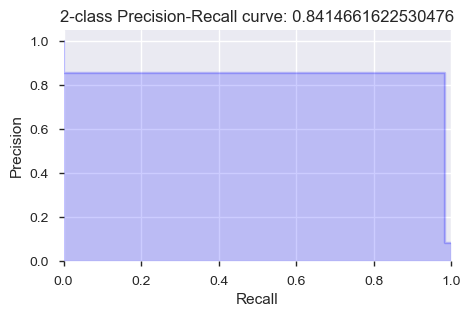

In [71]:
LR_pipeline_model = fit_model_show_metrics(LR_pipeline_model, all_data_pow,
                                           target)

Добавление признаков не дало никакого профита. Далее будем работать с данными без добавления степеней и логарифма

# Hyperparameter tuning for logistic regression

Попробуем найти наиболее подходящие параметры регуляризации с помощью GridSearch

In [73]:
my_scorer = make_scorer(recall_score, average='macro')

In [74]:
param_grid = dict(clf__C=[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
                  clf__penalty=['l1', 'l2'])

LR_grid = GridSearchCV(LR_pipe, param_grid=param_grid, scoring=my_scorer)

train data size :  (1849, 16) 
train target size:  1849 

[[712  16]
 [  1  64]] 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       728
           1       0.80      0.98      0.88        65

    accuracy                           0.98       793
   macro avg       0.90      0.98      0.94       793
weighted avg       0.98      0.98      0.98       793



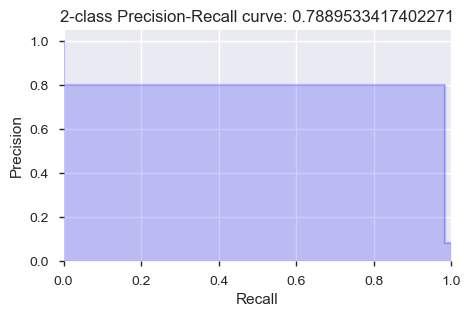

In [76]:
LR_grid = fit_model_show_metrics(LR_grid, all_data, target)

Использование GridSearch привело только к падению точности. Диагностировать наличие болезни у всех 100% пациентов пока не удалось

# KNN

Воспользуемся другим методом классификации. Возможно, он выдаст более точную модель.

In [78]:
KNN_pipe = Pipeline([
    ("transformer",
     FeatureUnion([('numeric',
                    make_pipeline(Columns(names=numeric_feats),
                                  StandardScaler())),
                   ('other', make_pipeline(Columns(names=binary_feats), ))])),
    ('clf', KNeighborsClassifier())
])

In [79]:
param_grid = dict(clf__algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'],
                  clf__weights=['uniform', 'distance'],
                  clf__n_neighbors=[1, 2, 5, 10, 15, 20, 50, 100])

KNN_grid = GridSearchCV(KNN_pipe, param_grid=param_grid, scoring=my_scorer)

train data size :  (1849, 16) 
train target size:  1849 

[[713  15]
 [ 30  35]] 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       728
           1       0.70      0.54      0.61        65

    accuracy                           0.94       793
   macro avg       0.83      0.76      0.79       793
weighted avg       0.94      0.94      0.94       793



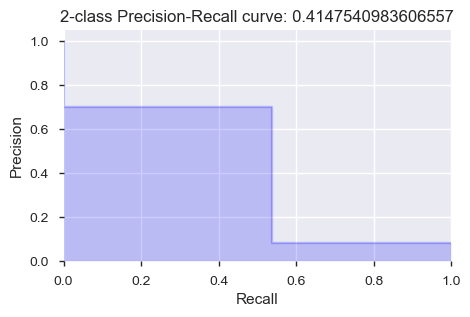

In [80]:
KNN_grid = fit_model_show_metrics(KNN_grid, all_data, target)

Метрики стали заметно хуже, чем у логистической модели

In [82]:
KNN_grid.best_estimator_

Pipeline(memory=None,
         steps=[('transformer',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric',
                                                 Pipeline(memory=None,
                                                          steps=[('columns',
                                                                  Columns(names=Index(['age', 'TSH', 'T3', 'TT4', 'FTI'], dtype='object'))),
                                                                 ('standardscaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('other',
                                                 

Даже с тюнингом большого количества параметров, данный метод не дал результатов лучших, чем логистическая регрессия: модель диагностирует всего немногим больше половины больных пациентов. Лучшим оказался метод LOO

# Decision tree

Попробуем также в качестве классификатора дерево решений. Не забываем, что работаем с несбалансированным датасетом и выставляем веса balanced. Остальные параметры будут подобраны.

In [83]:
tree_pipe = Pipeline([
    ("transformer",
     FeatureUnion([('numeric',
                    make_pipeline(Columns(names=numeric_feats),
                                  StandardScaler())),
                   ('other', make_pipeline(Columns(names=binary_feats), ))])),
    ('clf', DecisionTreeClassifier(class_weight='balanced'))
])

In [84]:
param_grid = dict(clf__criterion=['gini', 'entropy'],
                  clf__max_depth=range(1, 20))

tree_grid = GridSearchCV(tree_pipe, param_grid=param_grid, scoring=my_scorer)

train data size :  (1849, 16) 
train target size:  1849 

[[725   3]
 [  2  63]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       728
           1       0.95      0.97      0.96        65

    accuracy                           0.99       793
   macro avg       0.98      0.98      0.98       793
weighted avg       0.99      0.99      0.99       793



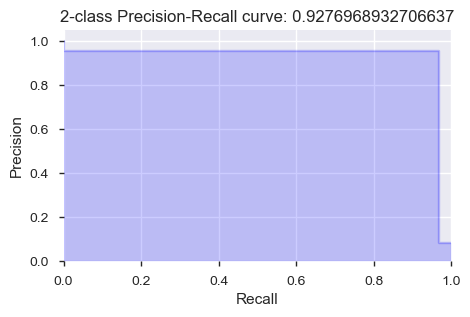

In [85]:
tree_grid = fit_model_show_metrics(tree_grid, all_data, target)

Recall чуть меньше, чем у тюнингованной логистической регрессии. При этом precision значительно больше. Так как recall не увеличился, данную модель считаем менее привлекательной, нежели логистическую

# SVC

In [87]:
SVC_pipe = Pipeline([
    ("transformer",
     FeatureUnion([('numeric',
                    make_pipeline(Columns(names=numeric_feats),
                                  StandardScaler())),
                   ('other', make_pipeline(Columns(names=binary_feats), ))])),
    ('clf', svm.SVC(class_weight='balanced'))
])

In [88]:
param_grid = dict(clf__C=[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
                  clf__kernel=['linear', 'rbf', 'poly', 'sigmoid'],
                  clf__degree=[1, 2, 3, 4])

SVC_grid = GridSearchCV(SVC_pipe, param_grid=param_grid, scoring=my_scorer)

train data size :  (1849, 16) 
train target size:  1849 

[[703  25]
 [  1  64]] 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       728
           1       0.72      0.98      0.83        65

    accuracy                           0.97       793
   macro avg       0.86      0.98      0.91       793
weighted avg       0.98      0.97      0.97       793



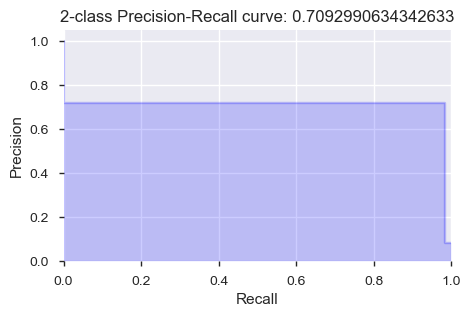

In [89]:
SVC_grid = fit_model_show_metrics(SVC_grid, all_data, target)

Recall точно такой же, как и у логистической модели, но precision чуть ниже. Делаем вывод, что самая простая и самая лучшая модель - логистическая регрессия с дефолтными параметрами

# Specific disease classification

Чтобы определить конкретное заболевание у пациента, которого первый классификатор посчитал больным, надо снова загрузить данные и обработать их. При этом классы теперь не объединяются

In [91]:
all_data_clf2 = pd.read_csv('Thyroid_Disease_dataset.csv')

#замена знаков ? на nan
all_data_clf2 = all_data_clf2.replace('?', np.nan)
#удаление переменных, имеющих константные значения
all_data_clf2 = all_data_clf2.drop(['TBG', 'TBG_measured', 'hypopituitary'], 1)
'''
#обязательно заполним пропущенные значения признаков у второго пациента, больного secondary_hypothyroid.
#значения признаков будут скопированы у второго пациента, имеющего это же заболевание
fillna_value_FTI=int(all_data_clf2[(all_data_clf2['Class']=='secondary_hypothyroid') & 
                               (all_data_clf2['FTI']==all_data_clf2['FTI'])]['FTI'].values[0])
all_data_clf2.loc[[1505],['FTI']] = all_data_clf2.loc[[1505], ['FTI']].fillna(fillna_value_FTI)

fillna_value_T4U=float(all_data_clf2[(all_data_clf2['Class']=='secondary_hypothyroid') & 
                               (all_data_clf2['T4U']==all_data_clf2['T4U'])]['T4U'].values[0])
all_data_clf2.loc[[1505],['T4U']] = all_data_clf2.loc[[1505], ['T4U']].fillna(fillna_value_T4U)
'''

#выделение численных переменных
to_numeric = ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']
for cat in to_numeric:
    all_data_clf2[cat] = pd.to_numeric(all_data_clf2[cat])

#перевод категориальных переменных в бинарные
all_data_clf2 = all_data_clf2.replace('t', 1)
all_data_clf2 = all_data_clf2.replace('f', 0)
all_data_clf2['sex'] = all_data_clf2['sex'].replace('M', 1)
all_data_clf2['sex'] = all_data_clf2['sex'].replace('F', 0)
all_data_clf2 = all_data_clf2.rename(index=str, columns={"sex": "Male"})
pipeline = make_pipeline(
    category_encoders.OneHotEncoder(handle_unknown="ignore",
                                    use_cat_names=True,
                                    cols=['referral_source']))
all_data_clf2 = pipeline.fit_transform(all_data_clf2)

#display(all_data_clf2[(all_data_clf2['Class']=='secondary_hypothyroid')].T)

#удаление избыточных переменных
all_data_clf2 = all_data_clf2[all_data_clf2.columns.drop(
    list(all_data_clf2.filter(regex='measured')))]
#удаление пропущенных значений
all_data_clf2 = all_data_clf2.dropna()
#приведение признака Male к бинарному виду
all_data_clf2['Male'] = all_data_clf2['Male'].astype(np.int64)

#выделение численных признаков
numeric_feats = all_data_clf2.dtypes[all_data_clf2.dtypes == "float64"].index
#обработка численных признаков
all_data_clf2 = all_data_clf2[all_data_clf2['age'] < 400]
all_data_clf2 = all_data_clf2.drop('T4U', 1)
numeric_feats = numeric_feats.drop('T4U', 1)
#выделение бинарных признаков
binary_feats = all_data_clf2.columns
for feat in numeric_feats:
    binary_feats = binary_feats.drop(feat, 1)

#Удалим переменные, у которых ratio для больных и здоровых почти одинаковый и переменные, имеющие константные значения
all_data_clf2 = all_data_clf2.drop([
    'referral_source_other', 'referral_source_SVI', 'referral_source_SVHD',
    'query_on_thyroxine', 'sick', 'query_hyperthyroid', 'lithium', 'tumor',
    'goitre', 'pregnant'
], 1)
binary_feats = binary_feats.drop([
    'referral_source_other', 'referral_source_SVI', 'referral_source_SVHD',
    'query_on_thyroxine', 'sick', 'query_hyperthyroid', 'lithium', 'tumor',
    'goitre', 'pregnant'
], 1)

Обучать второй классификатор будем только на действительно больных пациентах. Поэтому здоровых из этого датасета удаляем

In [92]:
all_data_clf2 = all_data_clf2[all_data_clf2['Class'] != 'negative']
all_data_clf2.shape

(216, 15)

Выделим целевую переменную

In [93]:
target_clf2 = all_data_clf2.pop('Class')
binary_feats = binary_feats.drop('Class', 1)

all_data_clf2 = all_data_clf2.dropna()
all_data_clf2.shape

(216, 14)

Попробуем избавиться от несбалансированности данных и сгенерируем пациентов с диагнозами, которые представлены в меньшинстве

In [94]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample(all_data_clf2, target_clf2)

Приведём сгенерированные данные к табличному виду

In [95]:
#Создадим датафрейм
X_resampled_pd = pd.DataFrame(data=X_resampled, columns=all_data_clf2.columns)
#Восстановим "бинарность" бинарных данных
X_resampled_pd[binary_feats] = X_resampled_pd[binary_feats].astype(np.int64)

display(X_resampled_pd.shape, X_resampled_pd.head())

y_resampled_pd = pd.Series(data=y_resampled, name='Class')

display(y_resampled_pd.shape, y_resampled_pd.head())

(408, 14)

,referral_source_SVHC,referral_source_STMW,age,Male,on_thyroxine,on_antithyroid_medication,thyroid_surgery,I131_treatment,query_hypothyroid,psych,TSH,T3,TT4,FTI
0,0,0,44.0,1,0,0,0,0,0,0,45.0,1.4,39.0,33.0
1,0,0,65.0,1,0,0,0,0,0,0,14.8,1.5,61.0,72.0
2,0,0,27.0,0,0,0,0,0,0,0,15.0,1.6,82.0,100.0
3,1,0,54.0,0,0,0,0,0,0,0,19.0,2.2,83.0,81.0
4,0,0,39.0,0,0,0,0,0,0,0,160.0,0.4,11.0,8.9


(408,)

0        primary_hypothyroid
1    compensated_hypothyroid
2    compensated_hypothyroid
3    compensated_hypothyroid
4        primary_hypothyroid
Name: Class, dtype: object

Разобьём датасет на тренировочный и тестовый сеты

In [96]:
train_data, test_data, train_target, test_target = train_test_split(
    X_resampled_pd,
    y_resampled_pd,
    test_size=0.3,
    random_state=17,
    stratify=y_resampled_pd)

In [99]:
LR_model_clf2 = Pipeline([
    ("transformer",
     FeatureUnion([('numeric',
                    make_pipeline(Columns(names=numeric_feats),
                                  StandardScaler())),
                   ('other', make_pipeline(Columns(names=binary_feats), ))])),
    ('clf', LogisticRegression(class_weight='balanced'))
])

In [100]:
LR_model_clf2 = fit_model_show_metrics(LR_model_clf2,
                                       X_resampled_pd,
                                       y_resampled_pd,
                                       auc_prc=False)

train data size :  (285, 14) 
train target size:  285 

[[38  1  2]
 [ 2 38  1]
 [ 0  0 41]] 

                         precision    recall  f1-score   support

compensated_hypothyroid       0.95      0.93      0.94        41
    primary_hypothyroid       0.97      0.93      0.95        41
  secondary_hypothyroid       0.93      1.00      0.96        41

               accuracy                           0.95       123
              macro avg       0.95      0.95      0.95       123
           weighted avg       0.95      0.95      0.95       123



В первой строке располагаются пациенты с заболеванием compensated hypothyroid , во второй - пациенты с заболеванием primary hypothyroid, в третьей - secondary_hypothyroid.

В первом столбце находятся пациенты, которых алгоритм классифицировал как больных compensated hypothyroid, во втором - как больных primary hypothyroid, в третьем - secondary_hypothyroid

Получается, данная модель случайно допустила ошибку 6 раз.
Ошибки в данной задаче имеют одинаково важную цену, поэтому будем использовать такую метрику качества как доля правильных ответов

In [101]:
LR_model_clf2.score(test_data, test_target)

0.9512195121951219

In [102]:
my_scorer = make_scorer(accuracy_score)

In [103]:
param_grid = dict(clf__C=[1e-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000],
                  clf__penalty=['l1', 'l2'])

LR_grid_clf2 = GridSearchCV(LR_pipe, param_grid=param_grid, scoring=my_scorer)

In [104]:
LR_grid_clf2 = fit_model_show_metrics(LR_model_clf2,
                                      X_resampled_pd,
                                      y_resampled_pd,
                                      auc_prc=False)

train data size :  (285, 14) 
train target size:  285 

[[38  1  2]
 [ 2 38  1]
 [ 0  0 41]] 

                         precision    recall  f1-score   support

compensated_hypothyroid       0.95      0.93      0.94        41
    primary_hypothyroid       0.97      0.93      0.95        41
  secondary_hypothyroid       0.93      1.00      0.96        41

               accuracy                           0.95       123
              macro avg       0.95      0.95      0.95       123
           weighted avg       0.95      0.95      0.95       123



In [105]:
LR_grid_clf2.score(test_data, test_target)

0.9512195121951219

С помощью GridSearch не удалось улучшить модель. Доля верных ответов классификатора конкретной болезни осталась на уровне чуть более 95%.